=====
tensor([])
=====
Parameter containing:
tensor([[5.1541]])
Parameter containing:
tensor([[78.4000]])
Parameter containing:
tensor([[78.4000]])
Parameter containing:
tensor([[78.4000]])
Parameter containing:
tensor([[78.4000]])
Parameter containing:
tensor([[78.4000]])
Parameter containing:
tensor([[78.4000]])
Parameter containing:
tensor([[78.4000]])
Parameter containing:
tensor([[78.4000]])
Parameter containing:
tensor([[78.4000]])


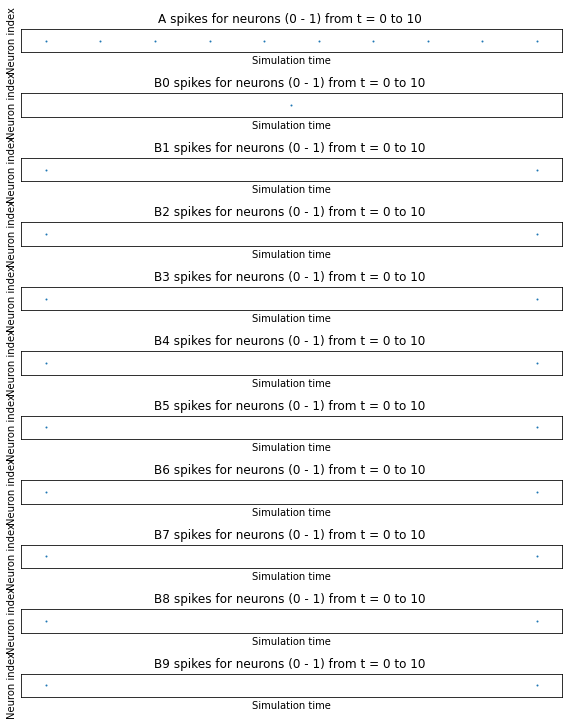

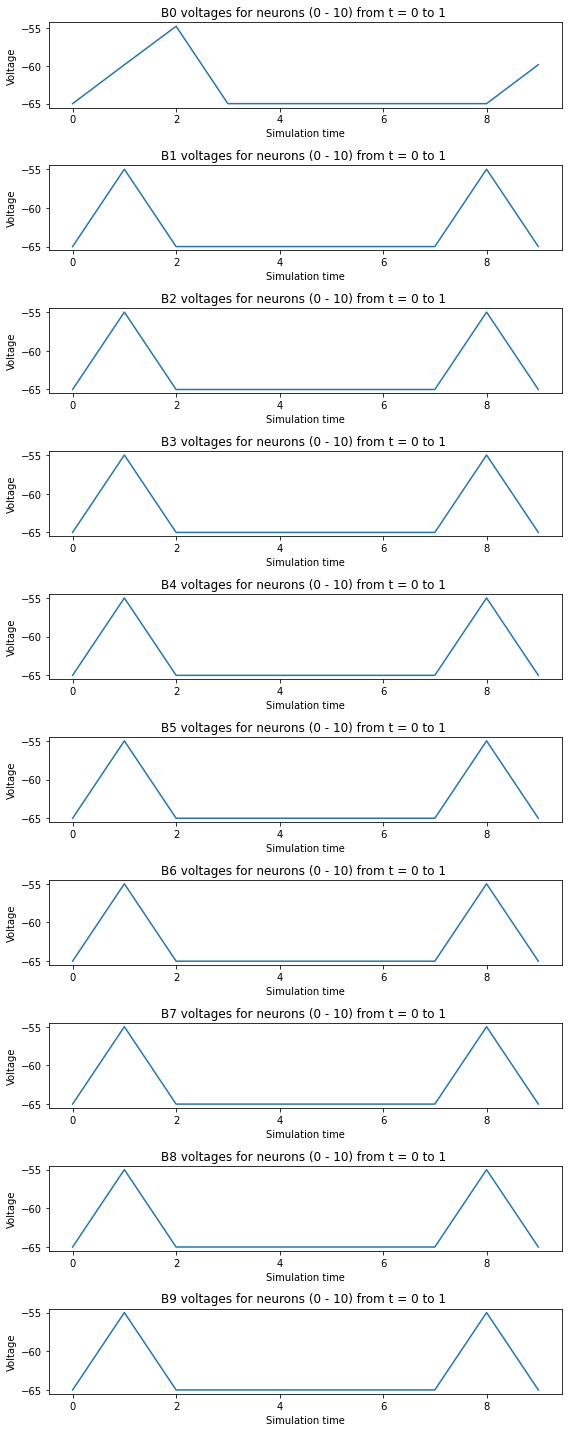

In [3]:
import torch
import matplotlib.pyplot as plt
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages
from bindsnet.learning import PostPre
%matplotlib inline
torch.manual_seed(0)

# Simulation time.
time = 10
epoch = 10
# all_time = 100 * epoch

# Create the network.
network = Network()

# Create and add input, output layers.
source_layer = Input(n=1, traces=True)
print("=====")
print(source_layer.x)
print("=====")
target_layer = LIFNodes(n=1, traces=True)

network.add_layer(
    layer=source_layer, name="A"
)
network.add_layer(
    layer=target_layer, name="B"
)

# Create connection between input and output layers.
forward_connection = Connection(
    source=source_layer,
    target=target_layer,
    # Normal(0.05, 0.01) weights.
    w=5 + 0.1 * torch.randn(source_layer.n, target_layer.n),
    update_rule=PostPre,
    nu=(1e-4, 1e-2),
    reduction=None,
    wmin=0.0,
    wmax=10.0,
    norm=78.4,
)

network.add_connection(
    connection=forward_connection, source="A", target="B"
)

# Create recurrent connection in output layer.
recurrent_connection = Connection(
    source=target_layer,
    target=target_layer,
    w=0.025 * (torch.eye(target_layer.n) - 1),
    # Small, inhibitory "competitive" weights.
)

network.add_connection(
    connection=recurrent_connection, source="B", target="B"
)

# Create and add input and output layer monitors.
source_monitor = Monitor(
    obj=source_layer,
    state_vars=("s",),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)
target_monitor = Monitor(
    obj=target_layer,
    state_vars=("s", "v"),  # Record spikes and voltages.
    time=time,  # Length of simulation (if known ahead of time).
)

network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=target_monitor, name="B")

# Create input spike data, 
# where each spike is distributed according to Bernoulli(0.1).
input_data = torch.ones(time, source_layer.n).byte()
inputs = {"A": input_data}
spikes = {}
voltages = {}
# Simulate network on input data.
# network.run(inputs=inputs, time=time)
for i in range(epoch):
    print(network.connections[("A", "B")].w)
    network.run(inputs=inputs, time=time, input_time_dim=1)
    # Retrieve and plot simulation spike, voltage data from monitors.
    # voltages = {"B": target_monitor.get("v")}
    voltages["B" + str(i)] = target_monitor.get("v")
    if i == 0:
        spikes["A"] = source_monitor.get("s")
    spikes["B"+str(i)] = target_monitor.get("s")
    network.reset_state_variables()  # Reset state variables.

plt.ioff()
plot_spikes(spikes, figsize=(8.0, 10))
plot_voltages(voltages, plot_type="line",figsize=(8.0, 20))
plt.show()